In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='161fa45c-278a-499e-b390-2e5fa077529d', project_access_token='p-0e7f52a70836350d18b2996d041242b522acae89')
pc = project.project_context


# Coursera Capstone Project

### Luigi De Marco, 10/5/2020

This Jupyter Notebook will be mainly used to complete the Coursera Capstone project in the IBM Data Science Series

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

In [3]:
# define filename
DATA_PATH = 'Data-Collisions.csv'

def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# Using pandas to read the data 
# Since the `DATE` column consists date-time information, we use Pandas parse_dates keyword for easier data processing
data_path = get_file_handle(DATA_PATH)

In [4]:
df = pd.read_csv(data_path)
df['INCDTTM'] =  pd.to_datetime(df['INCDTTM'])
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Feature Selection and Data Cleaning

In [5]:
# Choose predictive features
important_features = ['SEVERITYCODE', 'ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
df_features = df[important_features]
cols = df_features.columns

# Add a column corresponding to the season in which the collision occurred
mth_2_seas = np.array(['Winter', 'Winter', 'Spring', 'Spring', 'Spring',
              'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter'])
df_features['SEASON'] = mth_2_seas[df['INCDTTM'].dt.month - 1]


# Remove NA Rows and Unknown values
is_NaN = df_features.isnull()
nan_rows = np.sum(is_NaN.any(axis=1))
print('Of {0} rows, {1} contain NaN values.'.format(df_features.shape[0], nan_rows))
df_features = df_features.dropna() 
for k in cols:
    df_features = df_features[df_features[k] != 'Unknown']
print('After discarding NaN and Unknown values, we have {} entires'.format(df_features.shape[0]))


# Make Severity code 0 (property damage) or 1 (injury)
df_features['SEVERITYCODE'] = df_features['SEVERITYCODE'] - 1


# We will drop rows where categorical columns have fewer than 1000 records
record_min = 1000

for k in cols:
    temp_counts = df_features[k].value_counts()
    for i in temp_counts.keys():
        if temp_counts[i] < record_min:
            df_features = df_features[df_features[k] != i]
        
        
# Combine Different "Dark" Light Conditions
df_features['LIGHTCOND'] = df_features['LIGHTCOND'].replace(to_replace='Dark.+', regex=True, value='Dark')

# Finally balance the data

df0 = df_features[df_features['SEVERITYCODE'] == 0]
df1 = df_features[df_features['SEVERITYCODE'] == 1]

df0 = df0.sample(df1.shape[0])

df_bal = pd.concat([df0, df1], axis=0)
df_features = df_bal.sample(frac=1).reset_index(drop=True)



df_features.head()



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Of 194673 rows, 7148 contain NaN values.
After discarding NaN and Unknown values, we have 169781 entires


,SEVERITYCODE,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND,SEASON
0,1,Block,Overcast,Wet,Daylight,Spring
1,1,Block,Clear,Dry,Daylight,Fall
2,1,Intersection,Clear,Dry,Daylight,Summer
3,0,Block,Clear,Dry,Daylight,Spring
4,1,Block,Overcast,Wet,Daylight,Spring


## Data Visualization

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


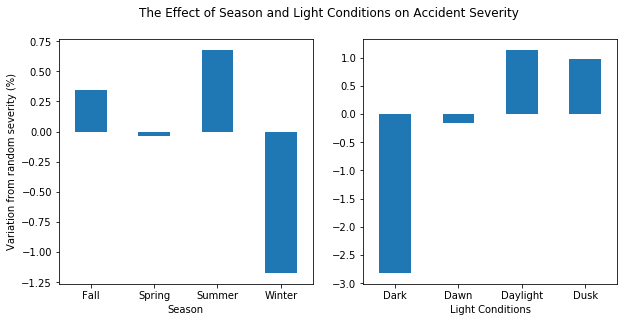

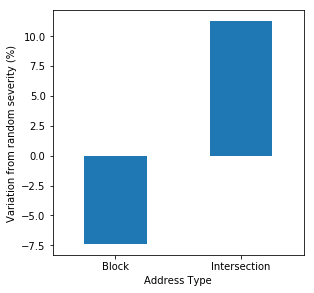

In [38]:
# Look at how some features correlate with the severity of car accidents
fig0, (ax0, bx0) = plt.subplots(1, 2, figsize=(10, 4.5))
plt.subplots_adjust(wspace=0.2)

# Subtract 0.5 from SEVERITYCODE to make the mean 0
df_plot = df_features[['SEVERITYCODE', 'SEASON', 'LIGHTCOND']]
df_plot['SEVERITYCODE'] = (df_plot['SEVERITYCODE'] - 0.5)*100.0



# Look at how seasons affect severity
df_plot.groupby('SEASON').mean().plot(kind='bar', ax=ax0, y='SEVERITYCODE')
labels = list(df_plot.groupby('SEASON').indices.keys())
ax0.set_xticklabels(labels, rotation='horizontal')
ax0.set_ylabel('Variation from random severity (%)')
ax0.get_legend().remove()
ax0.set_xlabel('Season')

df_plot.groupby('LIGHTCOND').mean().plot(kind='bar', ax=bx0, y='SEVERITYCODE')
labels = list(df_plot.groupby('LIGHTCOND').indices.keys())
bx0.set_xticklabels(labels, rotation='horizontal')
bx0.get_legend().remove()
bx0.set_xlabel('Light Conditions')

fig0.suptitle('The Effect of Season and Light Conditions on Accident Severity')

# plt.savefig('./report_figures/example_variations.png')

df_plot = df_features[['SEVERITYCODE', 'ADDRTYPE']]
df_plot['SEVERITYCODE'] = (df_plot['SEVERITYCODE'] - 0.5)*100.0

fig1, ax1 = plt.subplots(figsize=(4.5, 4.5))
df_plot.groupby('ADDRTYPE').mean().plot(kind='bar', ax=ax1, y='SEVERITYCODE')
labels = list(df_plot.groupby('ADDRTYPE').indices.keys())
ax1.set_xticklabels(labels, rotation='horizontal')
ax1.set_ylabel('Variation from random severity (%)')
ax1.get_legend().remove()
ax1.set_xlabel('Address Type')


plt.show()

While the above plots show how a single variable can predict the severity of an accident, the correlations between such variables can prove to be far more important in developing a predictive model. Below, we generate a 2D bar plot showing how correlations between the Season and Light Conditions can provide a more powerful predictor. 

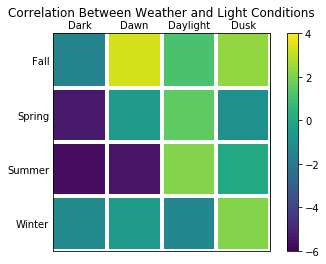

In [7]:
from matplotlib.ticker import AutoMinorLocator

wth_light = pd.pivot_table(df_plot, values='SEVERITYCODE', index='SEASON', columns='LIGHTCOND', aggfunc='mean')


fig1, ax1 = plt.subplots()
im = ax1.matshow(wth_light, clim=(-6, 4))
ax1.set_xticklabels([' '] + list(wth_light.columns))
ax1.set_yticklabels([' '] + list(wth_light.index))

minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.grid(which='minor', linewidth=4, color='white')

ax1.tick_params(which='both', length=0)
ax1.set_title('Correlation Between Weather and Light Conditions')

fig1.colorbar(im)

# plt.savefig('./report_figures/example_correlation.png')
plt.show()

## Data Preprocessing

Before building our models, we prepare the data by creating dummy columns for the categorical features. First, we look at the unique values in each column.  

In [8]:
cols = df_features.columns[1:]
for k in cols:
    print(df_features[k].unique())

['Block' 'Intersection']
['Overcast' 'Clear' 'Raining']
['Wet' 'Dry']
['Daylight' 'Dark' 'Dusk' 'Dawn']
['Spring' 'Fall' 'Summer' 'Winter']


For columns with only two types of values, we will replace them with 0 or 1.

In [9]:
Features = df_features[cols]

Features['ADDRTYPE'].replace(to_replace=['Block','Intersection'], value=[0,1],inplace=True)
Features['ROADCOND'].replace(to_replace=['Dry','Wet'], value=[0,1],inplace=True)

Features = pd.concat([Features,pd.get_dummies(Features['WEATHER'])], axis=1)
Features.drop('WEATHER', axis=1, inplace=True)

Features = pd.concat([Features,pd.get_dummies(Features['SEASON'])], axis=1)
Features.drop('SEASON', axis=1, inplace=True)

Features = pd.concat([Features,pd.get_dummies(Features['LIGHTCOND'])], axis=1)
Features.drop('LIGHTCOND', axis=1, inplace=True)

Features.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,ADDRTYPE,ROADCOND,Clear,Overcast,Raining,Fall,Spring,Summer,Winter,Dark,Dawn,Daylight,Dusk
0,0,1,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,1,0,0,0,0,0,1,0
2,1,0,1,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,0,1,0
4,0,1,0,1,0,0,1,0,0,0,0,1,0


In [39]:
X = Features.drop('ADDRTYPE', axis=1)
Y = df_features['SEVERITYCODE'].values

X.head()

,ROADCOND,Clear,Overcast,Raining,Fall,Spring,Summer,Winter,Dark,Dawn,Daylight,Dusk
0,1,0,1,0,0,1,0,0,0,0,1,0
1,0,1,0,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,1,0
4,1,0,1,0,0,1,0,0,0,0,1,0


## Model Construction

Now, we will explore different classifier models to determine which performs best. Specifically, we will look at K-Nearest Neighbors, Logistic Regression, and Decision tree models. 

Before building models, we will split the data into training, cross-validation (CV), and test sets. We will use the CV set to determine hyperparameters (e.g. the best K in KNN) and use the test data to score the model

In [40]:
from sklearn.model_selection import train_test_split
random_seed = 4
a = 0.2

X_temp, X_test, y_temp, y_test = train_test_split( X, Y, test_size=a, random_state=random_seed)
X_train, X_cv, y_train, y_cv = train_test_split( X_temp, y_temp, test_size=(a/(1-a)), random_state=random_seed)

print ('Train set:', X_train.shape,  y_train.shape)
print ('CV set:', X_cv.shape,  y_cv.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (65664, 12) (65664,)
CV set: (21889, 12) (21889,)
Test set: (21889, 12) (21889,)


### K-Nearest Neighbors Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [45]:
knn_acc = []

for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    y_hat = knn.predict(X_cv)
    knn_acc.append(metrics.accuracy_score(y_cv, y_hat))

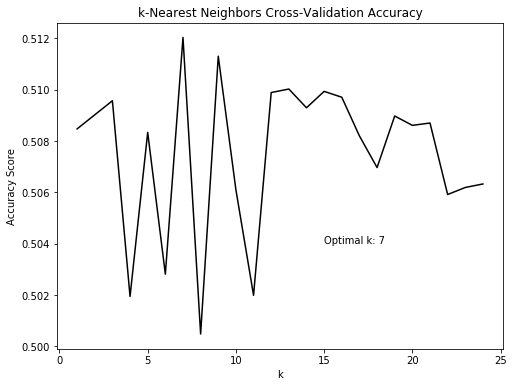

In [48]:
k_best = np.argmax(knn_acc) + 1

fig_knn, ax_knn = plt.subplots(figsize=(8, 6))

ax_knn.plot(range(1, 25), knn_acc, color='k')
ax_knn.set_xlabel('k')
ax_knn.set_ylabel('Accuracy Score')
ax_knn.set_title('k-Nearest Neighbors Cross-Validation Accuracy')
ax_knn.annotate('Optimal k: {}'.format(k_best), xy=(15, 0.504))
plt.show()

In [69]:
knn_best = KNeighborsClassifier(n_neighbors = k_best).fit(X_train,y_train)

print('Training accuracy: {0:.3f}'.format(metrics.accuracy_score(y_train,knn_best.predict(X_train))))
print('Cross-Validation accuracy: {0:.3f}'.format(metrics.accuracy_score(y_cv,knn_best.predict(X_cv))))
print('Test accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test,knn_best.predict(X_test))))

conf = metrics.confusion_matrix(y_test, knn_best.predict(X_test))
print('TP: {}, TN: {}, FP: {}, FN: {}'.format(conf[1,1], conf[0,0], conf[0,1], conf[1,0]))

Training accuracy: 0.512
Cross-Validation accuracy: 0.512
Test accuracy: 0.510
TP: 6454, TN: 4720, FP: 6191, FN: 4524


### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

C_vals = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
log_acc = []

for k in C_vals:
    LR = LogisticRegression(C=k, solver='liblinear').fit(X_train,y_train)
    y_hat = LR.predict(X_cv)
    log_acc.append(metrics.accuracy_score(y_cv, y_hat))

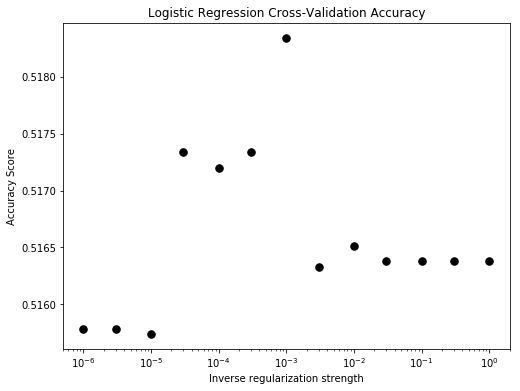

In [51]:
fig_log, ax_log = plt.subplots(figsize=(8, 6))

ax_log.plot(C_vals, log_acc, '.k', markersize=15)
ax_log.set_xlabel('Inverse regularization strength')
ax_log.set_ylabel('Accuracy Score')
ax_log.set_title('Logistic Regression Cross-Validation Accuracy')
ax_log.set_xscale('log')
# ax_log.annotate('Optimal k: {}'.format(k_best), xy=(20, 0.54))
plt.show()

In [68]:
C_best = 1E-3

LR_best = LogisticRegression(C=C_best, solver='liblinear').fit(X_train,y_train)

print('Training accuracy: {0:.3f}'.format(metrics.accuracy_score(y_train, LR_best.predict(X_train))))
print('Cross-Validation accuracy: {0:.3f}'.format(metrics.accuracy_score(y_cv, LR_best.predict(X_cv))))
print('Test accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, LR_best.predict(X_test))))

conf = metrics.confusion_matrix(y_test, LR_best.predict(X_test))
print('TP: {}, TN: {}, FP: {}, FN: {}'.format(conf[1,1], conf[0,0], conf[0,1], conf[1,0]))

Training accuracy: 0.520
Cross-Validation accuracy: 0.518
Test accuracy: 0.520
TP: 7300, TN: 4084, FP: 6827, FN: 3678


### SVM

In [73]:
from sklearn import svm

kernel_funcs = ['linear', 'poly', 'rbf', 'sigmoid']
svm_acc = []

for k in kernel_funcs:
    svm_model = svm.SVC(kernel=k, gamma='auto').fit(X_train,y_train)
    y_hat = svm_model.predict(X_cv)
    svm_acc.append(metrics.accuracy_score(y_cv, y_hat))

print(svm_acc)

[0.5147334277490977, 0.5182968614372516, 0.5182511763899675, 0.49074877792498517]


In [74]:
svm_best = svm.SVC(kernel='poly', gamma='auto').fit(X_train,y_train)

print('Training accuracy: {0:.3f}'.format(metrics.accuracy_score(y_train, svm_best.predict(X_train))))
print('Cross-Validation accuracy: {0:.3f}'.format(metrics.accuracy_score(y_cv, svm_best.predict(X_cv))))
print('Test accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test,svm_best.predict(X_test))))

conf = metrics.confusion_matrix(y_test, svm_best.predict(X_test))
print('TP: {}, TN: {}, FP: {}, FN: {}'.format(conf[1,1], conf[0,0], conf[0,1], conf[1,0]))

Training accuracy: 0.523
Cross-Validation accuracy: 0.518
Test accuracy: 0.520
TP: 6987, TN: 4385, FP: 6526, FN: 3991


### Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

tree_acc = []

for k in range(1, 16):
    dec_tree = DecisionTreeClassifier(max_depth = k).fit(X_train,y_train)
    y_hat = dec_tree.predict(X_cv)
    tree_acc.append(metrics.accuracy_score(y_cv, y_hat))

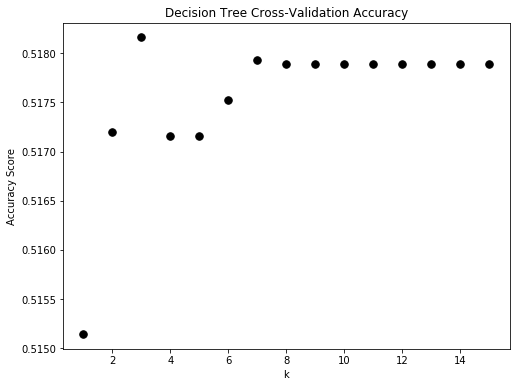

In [57]:
fig_tree, ax_tree = plt.subplots(figsize=(8, 6))

ax_tree.plot(range(1, 16), tree_acc, '.k', markersize=15)
ax_tree.set_xlabel('k')
ax_tree.set_ylabel('Accuracy Score')
ax_tree.set_title('Decision Tree Cross-Validation Accuracy')
plt.show()

In [70]:
depth_best=3

dec_tree_best = DecisionTreeClassifier(max_depth = depth_best).fit(X_train,y_train)

print('Training accuracy: {0:.3f}'.format(metrics.accuracy_score(y_train, dec_tree_best.predict(X_train))))
print('Cross-Validation accuracy: {0:.3f}'.format(metrics.accuracy_score(y_cv, dec_tree_best.predict(X_cv))))
print('Test accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, dec_tree_best.predict(X_test))))

conf = metrics.confusion_matrix(y_test, dec_tree_best.predict(X_test))
print('TP: {}, TN: {}, FP: {}, FN: {}'.format(conf[1,1], conf[0,0], conf[0,1], conf[1,0]))

Training accuracy: 0.522
Cross-Validation accuracy: 0.518
Test accuracy: 0.520
TP: 7614, TN: 3771, FP: 7140, FN: 3364


#### Decision Tree Visualization

In [60]:
!conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

0.20.3
Index(['ROADCOND', 'Clear', 'Overcast', 'Raining', 'Fall', 'Spring', 'Summer',
       'Winter', 'Dark', 'Dawn', 'Daylight', 'Dusk'],
      dtype='object')


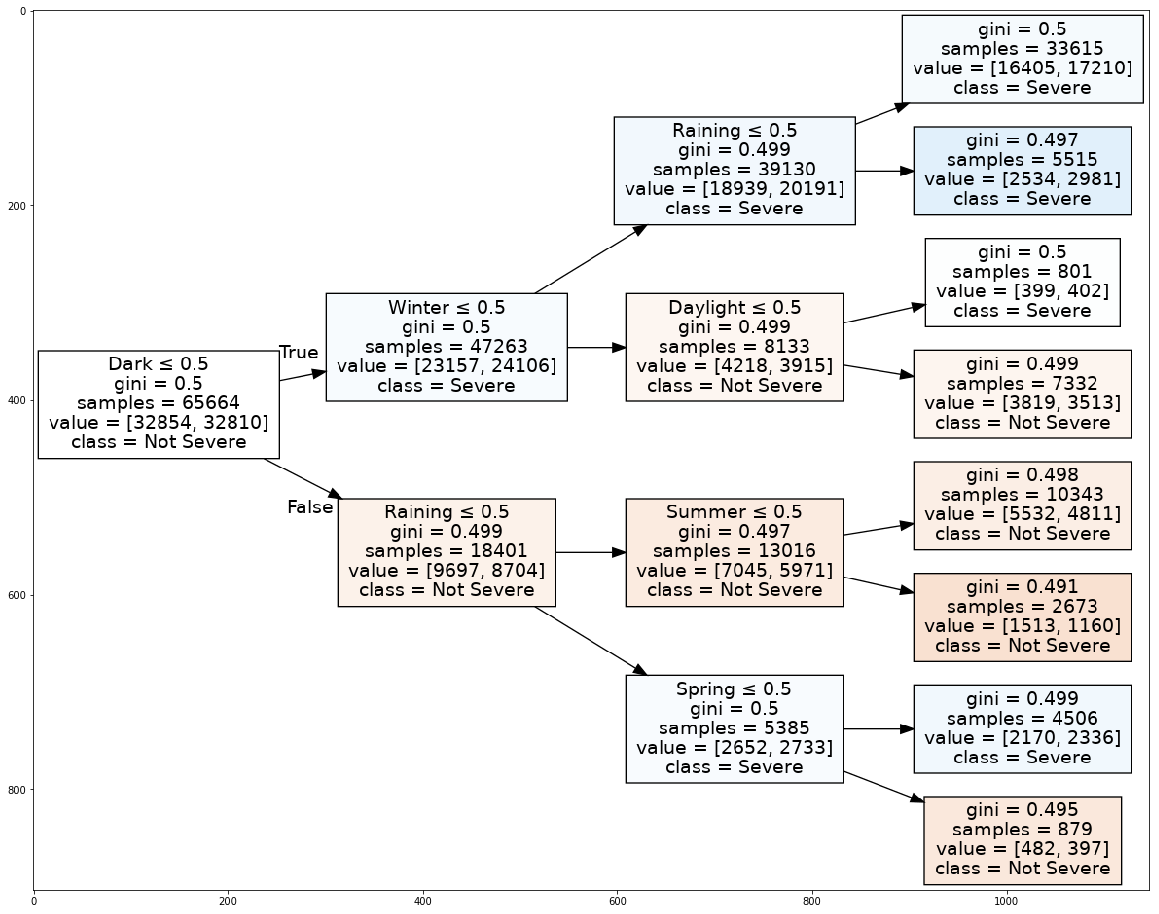

In [71]:
import sklearn
print(sklearn.__version__)

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 



dot_data = StringIO()
filename = "accident_tree.png"
featureNames = X.columns[:]
targetNames = ['Not Severe', 'Severe']



print(featureNames)
# print(targetNames)

out=tree.export_graphviz(dec_tree_best, feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True, rotate=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(20, 40))
plt.imshow(img,interpolation='nearest')